In [163]:
import numpy as np
import pygam
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import itertools
import scipy as sp
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import seaborn as sb
import pygraphviz
import scvelo as scv
import sys
import visutil
import os
plt.style.use('default')

In [164]:
FIG_DIR = "./"
DATA_DIR = "data/"
OUT_DIR = "locaTE_output/"
try:
    my_purple = matplotlib.colors.LinearSegmentedColormap.from_list("MyPurple", ['purple', 'purple', ])
    matplotlib.colormaps.register(cmap = my_purple)
    my_red = matplotlib.colors.LinearSegmentedColormap.from_list("MyRed", ['red', 'red', ])
    matplotlib.colormaps.register(cmap = my_red)
    my_grey = matplotlib.colors.LinearSegmentedColormap.from_list("MyGrey", ['#595959', '#595959', ])
    matplotlib.colormaps.register(cmap = my_grey)
except:
    pass

In [165]:
# Load AnnData object and locaTE output
adata = ad.read_h5ad(os.path.join(DATA_DIR, "adata_subset_tf.h5ad"))
adata = adata[:, adata.var.istf]
adata.uns["L"] = np.load(os.path.join(OUT_DIR, "L.npy"))
adata.uns["P"] = np.load(os.path.join(DATA_DIR, "P_kappavelo.npy"))
adata.uns["R"] = np.load(os.path.join(DATA_DIR, "R.npy"))
G = np.load(os.path.join(OUT_DIR, "G.npy"))
adata.uns["G"] = np.swapaxes(G.reshape(-1, adata.shape[1], adata.shape[1]), 1, 2).reshape(-1, adata.shape[1]**2) # fix Julia orientation
# NMF
U = np.load(os.path.join(OUT_DIR, "U.npy")).astype(np.float64)
V = np.load(os.path.join(OUT_DIR, "V.npy")).astype(np.float64)
V = np.swapaxes(V.reshape(adata.shape[1], adata.shape[1], -1), 0, 1).reshape(adata.shape[1]**2, -1) # fix Julia orientation
adata.uns["U"] = U
adata.uns["V"] = V.T 
del U, V

In [166]:
is_stress_gene = (adata.var.index == "Fos") | (adata.var.index == "Egr1")
is_stress_interaction = np.array([(x | y) for (x, y) in list(itertools.product(is_stress_gene, is_stress_gene))])
# filter out stress genes and stress interactions
adata = adata[:, ~is_stress_gene]
adata.uns["G"] = adata.uns["G"][:, ~is_stress_interaction]
adata.uns["V"] = adata.uns["V"][:, ~is_stress_interaction]
# ignore genes
is_ignore_gene = adata.var.index.isin(["Hmgb2", "Hmgb3", "Myb", "Myc",])
is_ignore_interaction = np.array([(x | y) for (x, y) in list(itertools.product(is_ignore_gene, is_ignore_gene))])
adata = adata[:, ~is_ignore_gene]
adata.uns["G"] = adata.uns["G"][:, ~is_ignore_interaction]
adata.uns["V"] = adata.uns["V"][:, ~is_ignore_interaction]

In [167]:
# Myeloid-Erythroid key interaction Gata1:Spi1
J_my_ery_net = np.zeros((adata.shape[1], adata.shape[1]))
for (i, j) in itertools.permutations(['Gata1', 'Spi1'], 2):
    J_my_ery_net[np.where(adata.var.index == i)[0][0], np.where(adata.var.index== j)[0][0]] = 1
J_my_ery_net_closure = (sp.linalg.expm(J_my_ery_net) > 0) - sp.eye(J_my_ery_net.shape[0])

In [168]:
adata.obs['celltype'] = adata.obs['original_clusters']
clustdict = {x : x.split(" ")[0].split(".")[0] for x in adata.obs.celltype.unique()}
adata.obs['celltype_coarse'] = [clustdict[x] for x in adata.obs.celltype]

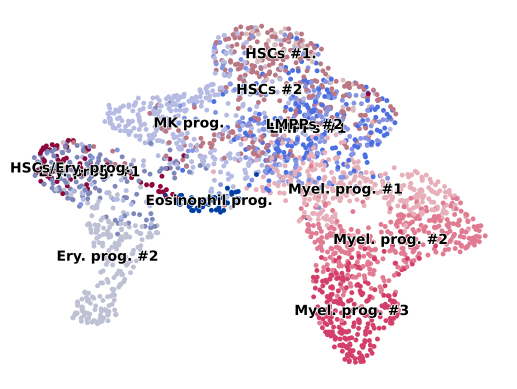

In [169]:
scv.pl.scatter(adata, basis = "X_umap", color="celltype", dpi=100, title='', cmap = "rainbow")

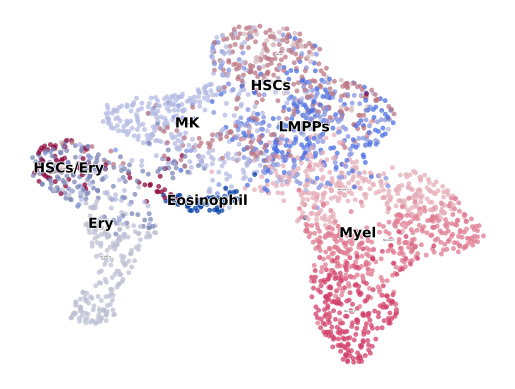

In [170]:
adata.uns['celltype_coarse_colors'] = adata.uns['celltype_colors']
ax = scv.pl.scatter(adata, basis='X_umap', color = "celltype", show=False, alpha=0.75, legend_fontsize = 0, dpi = 100)
scv.pl.scatter(adata, basis = "X_umap", color="celltype_coarse", title='', alpha = 0, ax = ax)

In [171]:
# NMF
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.pseudotime, u) for u in adata.uns["U"].T]
U_gam = np.vstack([g.predict(adata.obs.pseudotime) for g in coeff_gam]).T
perm = np.argsort([np.dot(adata.obs.pseudotime, x / sum(x)) for x in U_gam.T])
# permute U, V permanently
adata.uns["U"] = adata.uns["U"][:, perm]
adata.uns["V"] = adata.uns["V"][perm, :]

Text(0, 0.5, 'Module activity')

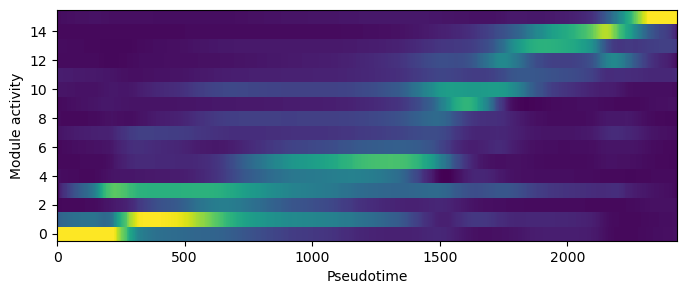

In [172]:
plt.figure(figsize = (8, 3))
plt.imshow(U_gam[np.argsort(adata.obs.pseudotime), :][:, perm].T, interpolation = "none", origin = "lower", vmax = np.quantile(U_gam, 0.99))
plt.axis("auto"); 
plt.xlabel("Pseudotime")
plt.ylabel("Module activity")

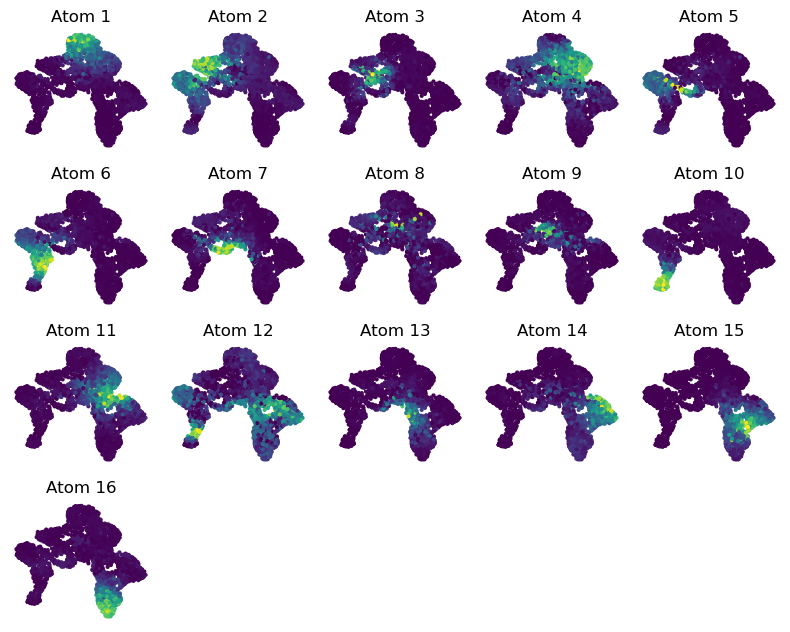

In [173]:
plt.figure(figsize = (8, 8))
for i in range(adata.uns["U"].shape[1]):
    plt.subplot(5, 5, i+1)
    plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], c = adata.uns["U"][:, i], s = 4)
    plt.title("Atom {}".format(i+1))
    plt.axis("off")
plt.tight_layout()

In [174]:
# Wasserstein distance between regulatory module activities
import ot 
import itertools
from tqdm import tqdm
import pandas as pd
C = np.zeros((adata.uns["U"].shape[1], adata.uns["U"].shape[1]))
for (i, j) in tqdm(itertools.product(range(adata.uns["U"].shape[1]), range(adata.uns["U"].shape[1]))):
    if i > j:
        C[i, j] = ot.emd2(adata.uns["U"][:, i] / adata.uns["U"][:, i].sum(), adata.uns["U"][:, j] / adata.uns["U"][:, j].sum(), adata.obsm["C"])
        C[j, i] = C[i, j]

233it [02:01,  1.17s/it]RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
256it [02:25,  1.76it/s]


Text(0.5, 1.0, 'Regulatory modules')

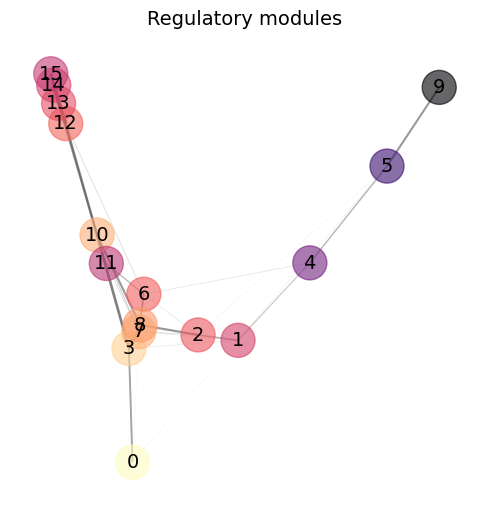

In [175]:
# Plot graph layout of regulatory modules
import sklearn as sk
A = sk.neighbors.NearestNeighbors(n_neighbors=5, metric = 'precomputed').fit(C).kneighbors_graph(C).toarray()
A = 0.5*(A + A.T)

K = np.exp(-2.5*C / np.median(C)) * A
K /= K.max()
t = np.array([visutil.approx_hitting_time(K / K.sum(-1).reshape(-1, 1), 0, j) for j in range(K.shape[0])])
g = nx.Graph(K)

nx.set_node_attributes(g, {i : np.exp(-t[i] / t.max()) for i in range(len(t))}, "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
pos = nx.spectral_layout(g)
# pos = nx.spring_layout(g)
# discard self loops
g.remove_edges_from(nx.selfloop_edges(g))
plt.figure(figsize = (5, 5))
module_names = {i : str(i) for i in range(adata.uns["U"].shape[1])}
visutil.draw(g, 
             gene_names = [str(module_names[i]) if i in module_names.keys() else "" for i in range(K.shape[0])], 
             thresh = 0.0, pos = pos, 
             kwargs_nodes = {"cmap" : plt.cm.magma, "alpha" : [0.6 if i in module_names.keys() else 0.3 for i in range(K.shape[0])], }, 
             kwargs_edges = {})
plt.tight_layout()
plt.axis("off")
plt.title("Regulatory modules", fontsize = 14)

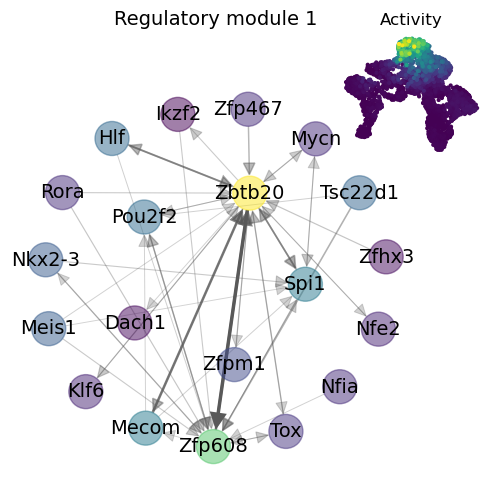

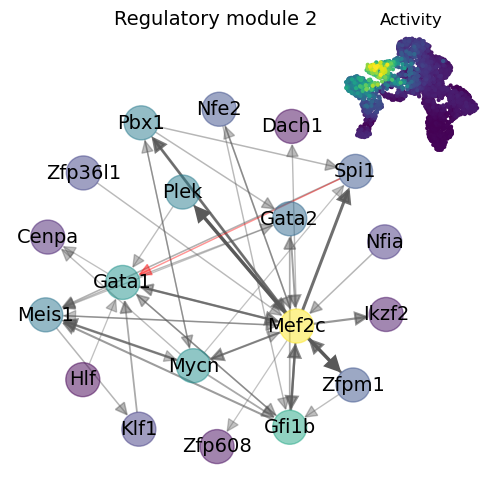

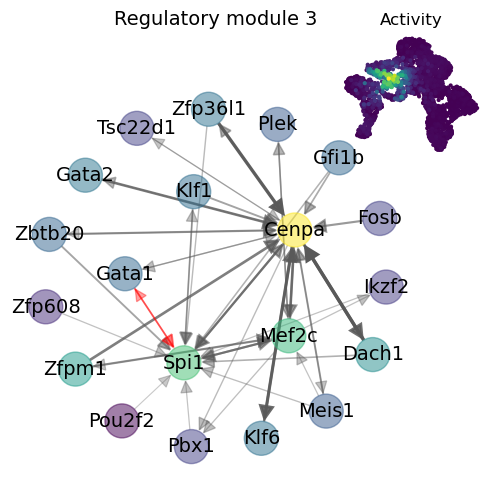

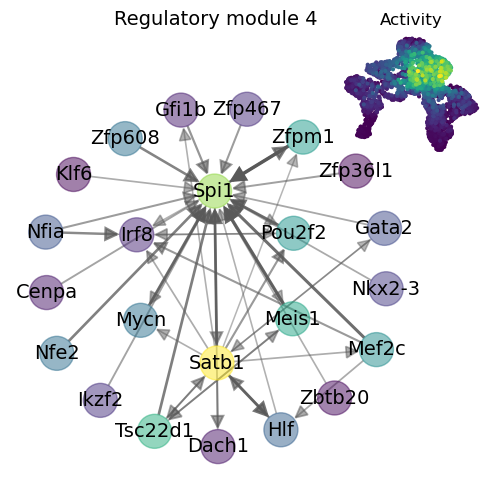

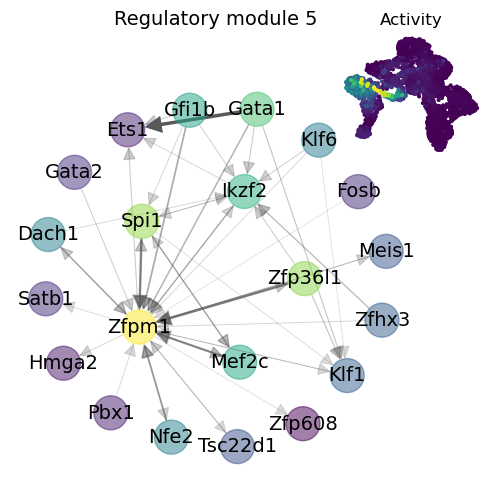

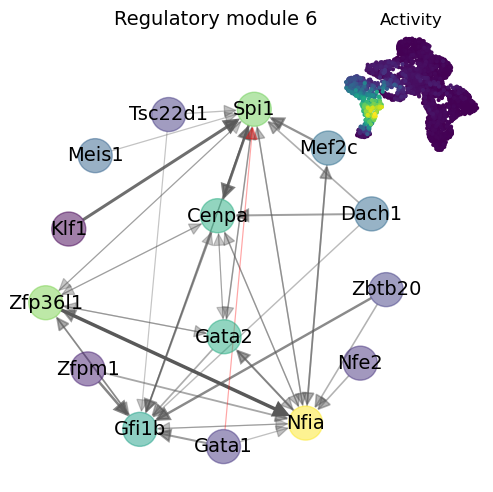

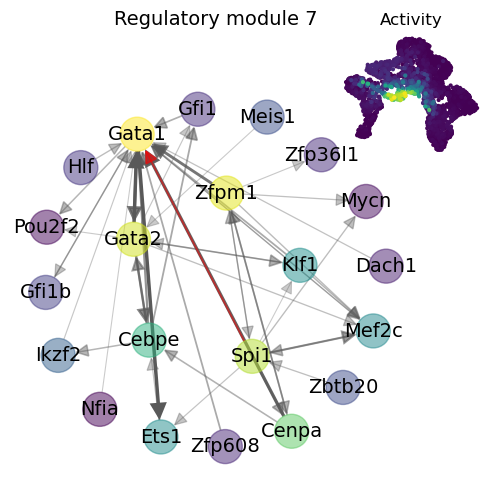

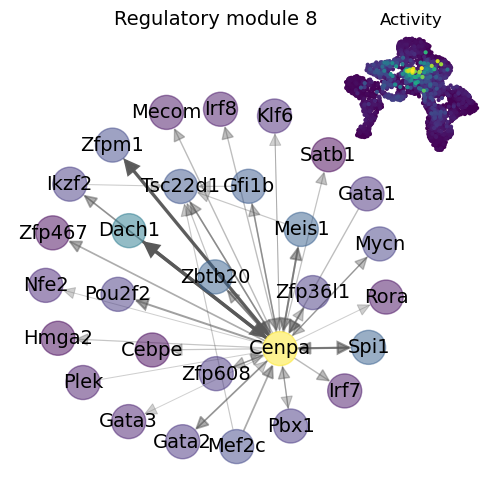

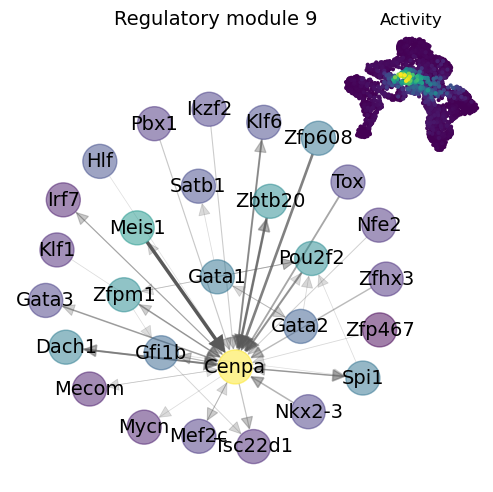

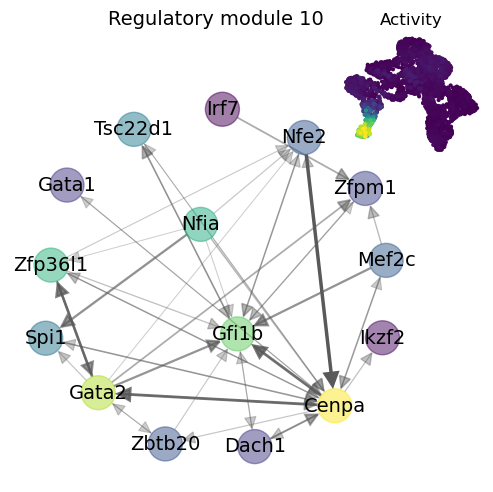

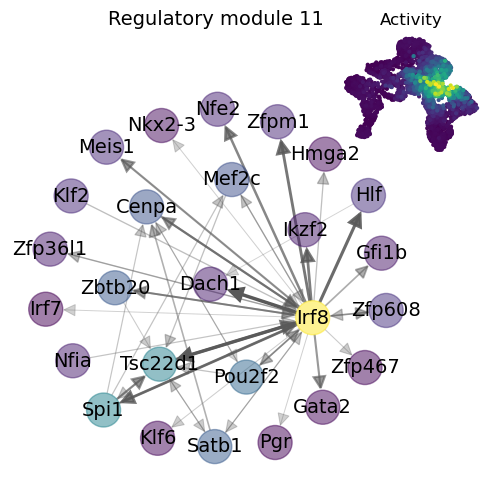

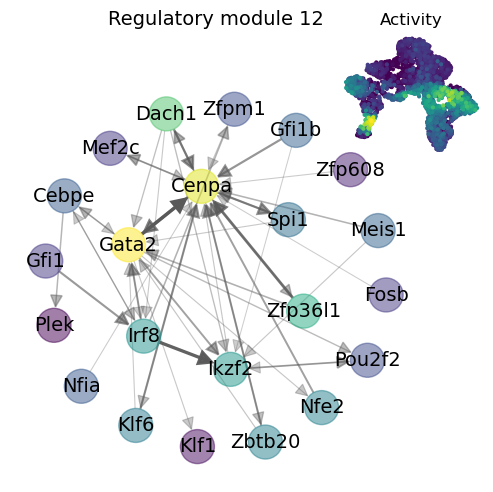

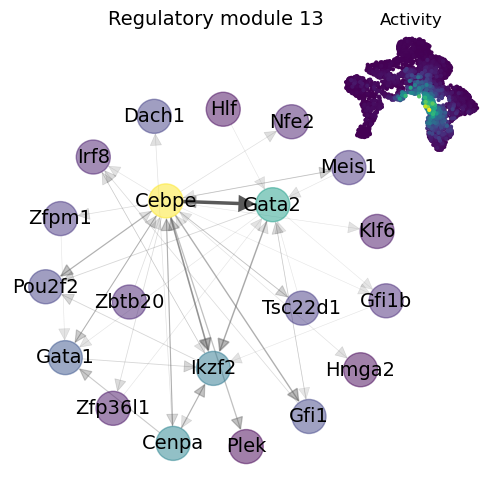

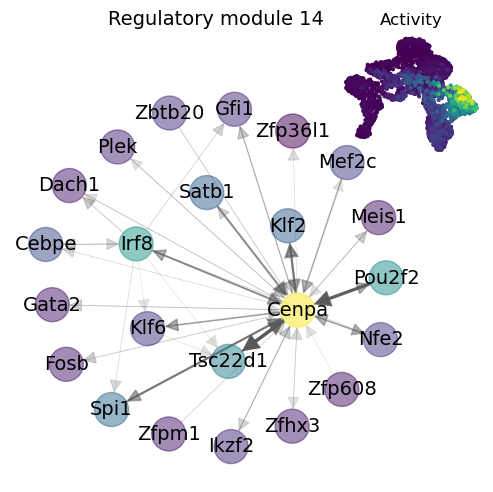

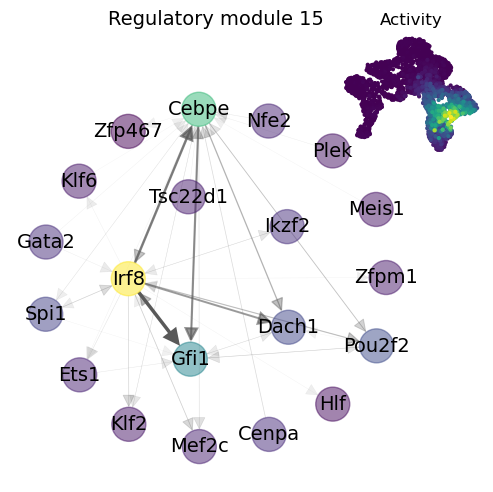

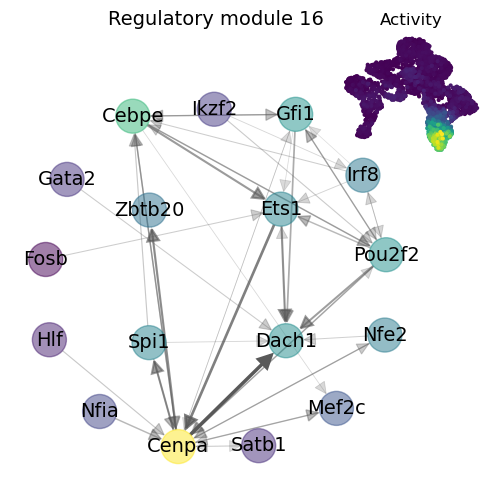

In [176]:
# Plot regulatory module networks and activities
for i in range(adata.uns["V"].shape[0]):
    A = adata.uns["V"][i, :].reshape(adata.shape[1], adata.shape[1])
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
    nx.set_edge_attributes(g, {(i, j) : J_my_ery_net[i, j] for (i, j) in g.edges}, name = "ref")
    plt.figure(figsize = (5, 5))
    visutil.draw(g, adata.var.index, thresh = 0.975, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=0")
    plt.gca().axis("off")
    ax = plt.gca()
    axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
    axin.axis("off")
    p = adata.uns["U"][:, i]
    axin.scatter(adata.obsm["X_umap"][np.argsort(p), 0], adata.obsm["X_umap"][np.argsort(p), 1], c = np.sort(p), s = 4)
    axin.set_title("Activity")
    plt.title("Regulatory module {}".format(i+1), fontsize = 14)
    plt.tight_layout()

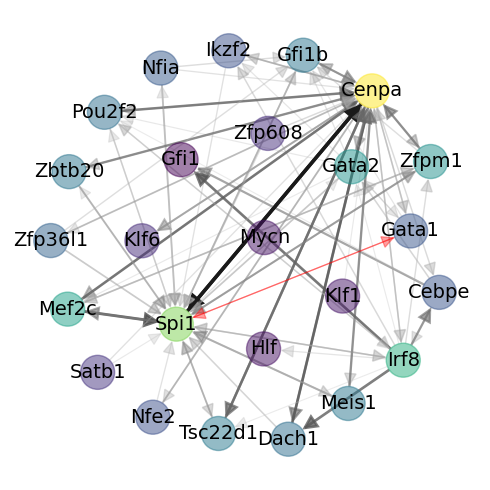

In [177]:
# Plot static network obtained by aggregating locaTE scGRNs
A = np.mean(adata.uns["G"][adata.obs.pseudotime < np.quantile(adata.obs.pseudotime, 0.9), :], axis = 0).reshape(adata.shape[1], adata.shape[1])
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
nx.set_edge_attributes(g, {(i, j) : J_my_ery_net[i, j] for (i, j) in g.edges}, name = "ref")
fig = plt.figure(figsize = (5, 5))
visutil.draw(g, adata.var.index, thresh = 0.95, cmap_dict = {0 : "Greys", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=2")
plt.axis("off")
plt.tight_layout()